/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
step 1: elapsed 1.0610568523406982
step 2: elapsed 0.01504659652709961
step 3: elapsed 0.09223222732543945
step 4: elapsed 0.5470888614654541
step 5: elapsed 0.005967378616333008
step 5: elapsed 0.029551982879638672

total elapsed: 1.753068208694458


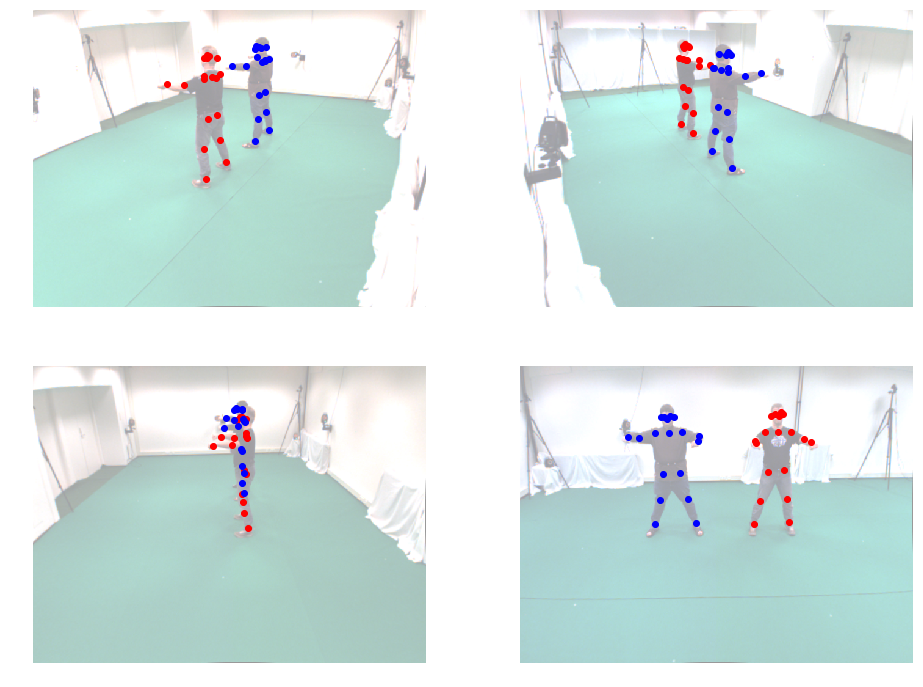

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

# **************************** #
FRAME = 0
# **************************** #

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, FRAME)

# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut

_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================

from mvpose.algorithm.candidate_selection import project_human_to_2d

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
plt.show()

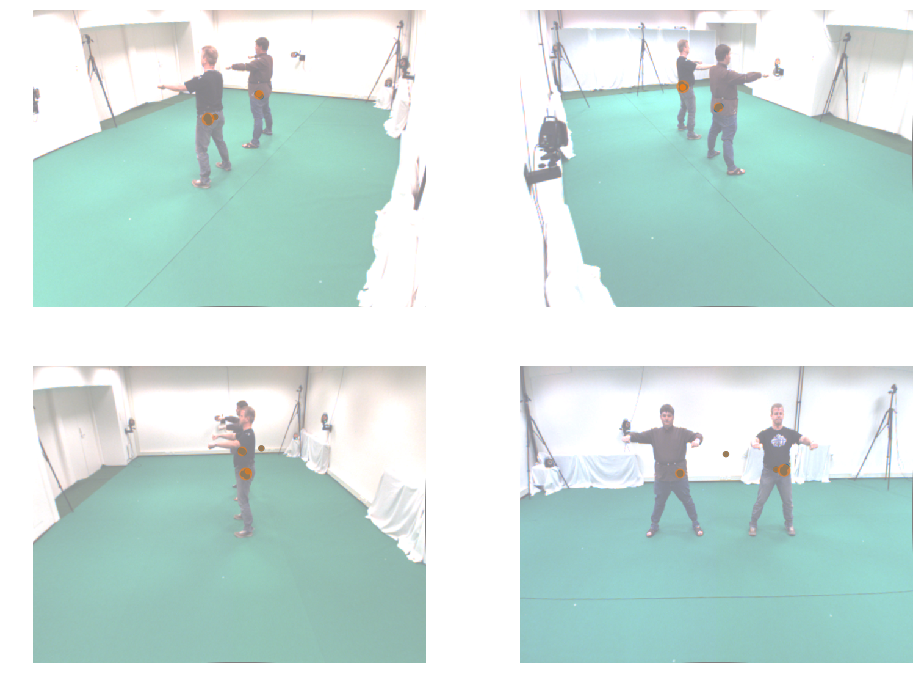

In [2]:
import mvpose.geometry.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


centers3d_with_w = Debug.meanshift.centers3d[JOINT]
centers3d = centers3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(2, 2, cid+1)
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
    centers2d = cam.projectPoints_undist(centers3d)
    ax.scatter(centers2d[:,0], centers2d[:,1], s=centers3d_with_w[:,3] * 50, alpha=0.5)
    
plt.show()

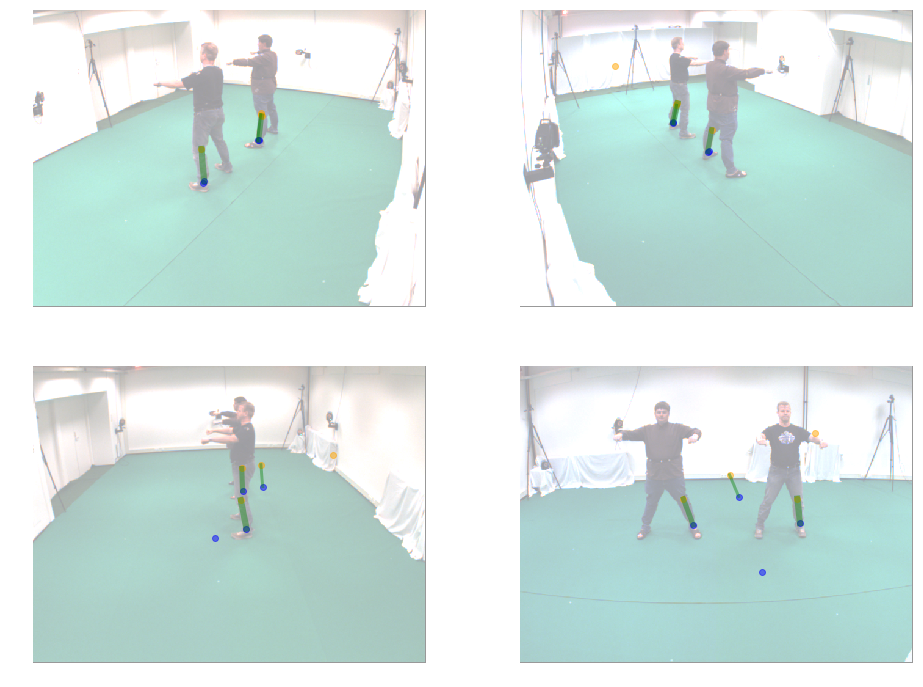

In [3]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in np.squeeze(maskA):
        for _b in np.squeeze(maskB):
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

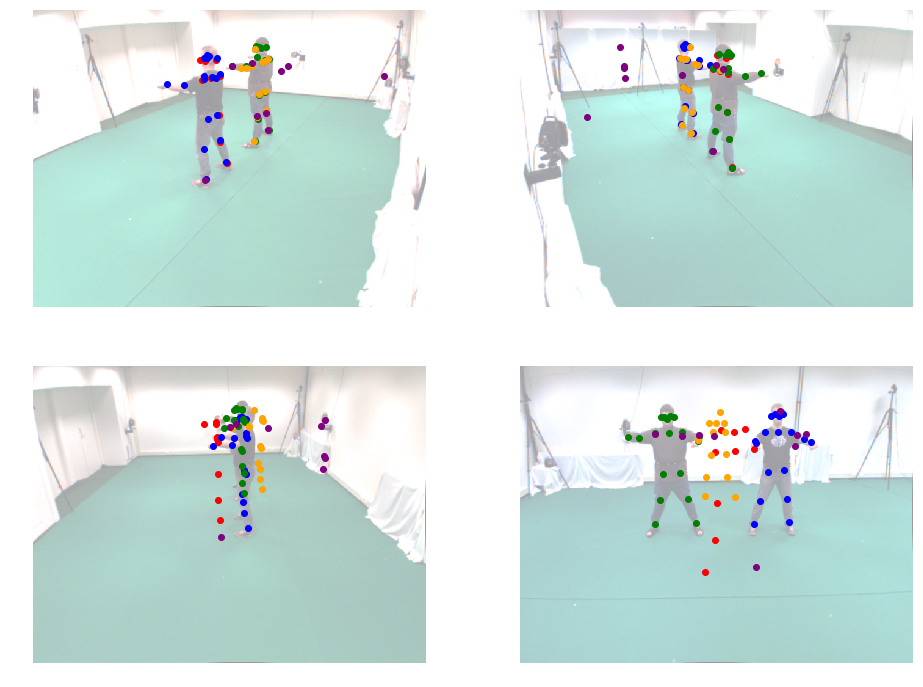

In [4]:
from mvpose.algorithm.candidate_selection import project_human_to_2d

Humans = Debug.human_candidates

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'orange', 'purple']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()